# Processing data using auvlib

First, let's import all of the modules needed for this part of the tutorial. We are going to work mostly with auvlib and matplotlib.

In [1]:
import matplotlib.pyplot as plt
from auvlib.bathy_maps import mesh_map, map_draper
from auvlib.data_tools import xtf_data, std_data, csv_data
import numpy as np
import os
import random
import math
from PIL import Image

## Looking at meshes

Now let us read some all data that we processed like before to convert into [`mbes_ping`](https://nilsbore.github.io/auvlib-docs/std_data.html?highlight=mbes_pi#auvlib.data_tools.std_data.mbes_ping) and do some more interesting stuff with it. In the next step, we are going to create and visualize a mesh from the multibeam data.

In [2]:
std_pings = std_data.mbes_ping.read_data("example_data/std_pings.cereal")
sound_speeds = csv_data.csv_asvp_sound_speed.parse_file("example_data/sound_speed.asvp")

The [`mesh_map`](https://nilsbore.github.io/auvlib-docs/mesh_map.html?highlight=mesh_map#module-auvlib.bathy_maps.mesh_map) library contains functions for working with meshes.

In [3]:
# create a mesh with resolution .5m
V, F, bounds = mesh_map.mesh_from_pings(std_pings, .5)
mesh_map.show_mesh(V, F) # show the mesh

Now we are going to load the sidescan data and drape the measurements onto the multibeam mesh by tracing imaginary rays through the water and match their travel times to the actual sidescan beams.

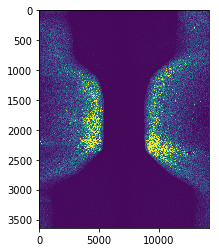

In [4]:
# read and show a waterfall image like before
xtf_pings = xtf_data.xtf_sss_ping.read_data("example_data/xtf_pings.cereal")
im = xtf_data.make_waterfall_image(xtf_pings)
plt.imshow(im, vmin=0, vmax=10, aspect=5.)
plt.show()

## Draping a mesh with sidescan data

Now we are going to associate the return times of the sidescan
pings to points on the mesh. This is done by tracing virtual
rays to the mesh to check how far away they are from the mesh
and (with the sound speeds) thus how long it would take for
the acoustic waves of the sidescan to travel there. These
computed times are then associated to the real times of the sidescan.
For more information, see the [`MapDraper`](https://nilsbore.github.io/auvlib-docs/map_draper.html?highlight=map_images#auvlib.bathy_maps.map_draper.MapDraper) data structure.

In [5]:
# often we need to correct the yaw of sidescan sensor
# it is not strictly needed in this particular case
sensor_yaw = 2.*math.pi/180.
Vb, Fb, Cb = map_draper.get_vehicle_mesh() # get a mesh for visualizing the data collection vehicle
draper = map_draper.MapDraper(V, F, xtf_pings, bounds, sound_speeds) # create a draping object
draper.set_sidescan_yaw(sensor_yaw)
draper.set_vehicle_mesh(Vb, Fb, Cb)
draper.set_ray_tracing_enabled(False) # no need to account for refraction as we are close to ground
draper.set_close_when_done(False) # do not close the viewer when done draping
draper.set_intensity_multiplier(0.1) # allows modifying the intesities of sidescan on mesh
draper.show() # show the viewer and drape
map_images = draper.get_images() # the resulting map image data structure
print "Got map images: ", len(map_images)
if len(map_images) > 0:
    map_draper.write_data(map_images, "example_data/map_images.cereal") # save for later

Got map images:  0


Now let us load the resulting map image data structure and inspect the results.

Text(0.5,1,'Depth')

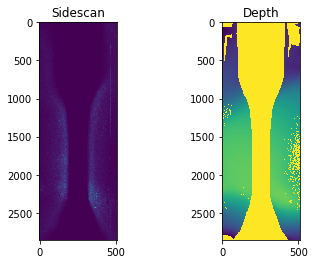

In [6]:
map_images = map_draper.sss_map_image.read_data("example_data/map_images.cereal")
fig, ax = plt.subplots(1, 2)
ax[0].imshow(map_images[0].sss_waterfall_image, aspect=0.5)
ax[0].set_title("Sidescan")
ax[1].imshow(map_images[0].sss_waterfall_depth, aspect=0.5, vmax=-50.)
ax[1].set_title("Depth")

## Creating a dataset for training a network

Let us add some convenience functions for converting the waterfall images into smaller slices.

In [7]:

def convert_waterfall_to_slices(wf_sss, wf_depth, image_height=32):

    image_width = wf_sss.shape[1]/2
    wf_length = wf_sss.shape[0]

    sss_slices = []
    depth_slices = []

    for i in xrange(0, wf_length-image_height, image_height/2):
        sss_slice_left = wf_sss[i:i+image_height, :image_width]
        depth_slice_left = wf_depth[i:i+image_height, :image_width]
        sss_slice_right = wf_sss[i:i+image_height, image_width:]
        depth_slice_right = wf_depth[i:i+image_height, image_width:]

        sss_slices.append(sss_slice_right)
        depth_slices.append(depth_slice_right)
        sss_slices.append(np.fliplr(sss_slice_left))
        depth_slices.append(np.fliplr(depth_slice_left))

    return sss_slices, depth_slices

def rescale_slices(slices):

    slices = [np.array(Image.fromarray((255.*np.rot90(s)).astype(np.uint8)).resize((256, 256), Image.ANTIALIAS)) for s in slices]

    return slices

def normalize_intensities(sss_slices):

    new_slices = []
    for s in sss_slices:
        m = np.mean(s[s>.1])
        ss = s.copy()
        if m != 0 and not np.isnan(m):
            ss *= .3/m
        new_slices.append(ss)

    return new_slices

We are now ready to go the whole way and convert the waterfall images to slices that we can later feed into a neural network.

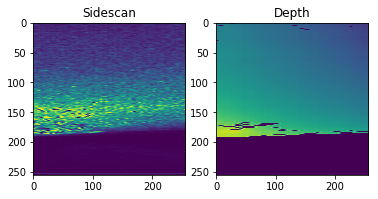

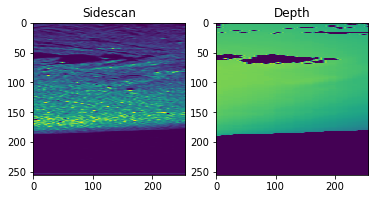

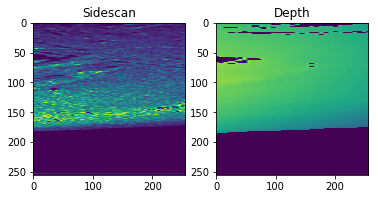

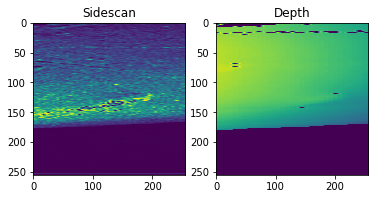

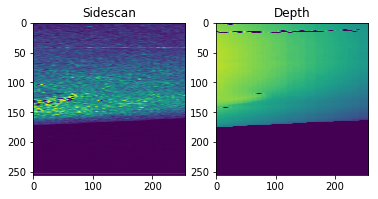

In [8]:
image_height = 64
image_width = map_images[0].sss_waterfall_image.shape[1]/2

# Let's start by cutting the waterfall images into slices
sss_slices = []
depth_slices = []
for map_image in map_images:
    s, d = convert_waterfall_to_slices(map_image.sss_waterfall_image, map_image.sss_waterfall_depth, image_height)
    sss_slices.extend(s)
    depth_slices.extend(d)

# normalize the depth slices to an interval
max_depth = -55. #-11.
min_depth = -70. #-19.
depth_slices = [1./(max_depth - min_depth)*(d - min_depth*(d != 0).astype(np.float)) for d in depth_slices]

# filter slices which are too dark (too deep)
min_depth_mean = 0.2 # 0.3
sss_slices, depth_slices = map(list,zip(*[(s, d) for s, d in zip(sss_slices, depth_slices) if np.mean(d) > min_depth_mean]))

# make the sidescan images look good by normalizing them
sss_slices = normalize_intensities(sss_slices)

# convert to 256x256 8 bit grayscale images
depth_slices = rescale_slices(depth_slices)
sss_slices = rescale_slices(sss_slices)

# look at 5 images
index = 70
for s, d in zip(sss_slices[index:index+5], depth_slices[index:index+5]):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(s)
    ax[0].set_title("Sidescan")
    ax[1].imshow(d)
    ax[1].set_title("Depth")

## Saving the dataset

When training a machine learning model, it is good practice to divide your dataset into
"training", "validation" and "test" subsets. The idea is that you optimize the parameters
of the model on the training set, validate the effectiveness of the model by trying it
on the separate data of the validation set, and report your results on the test set.
We will follow this practive when saving our data by putting the image pairs in three
different folders, called `train`, `val` and `test`. When done, you can open the
folder `sss2depth` and look at the results.

In [9]:
# The directory where we'll save the dataset
dataroot = "sss2depth"

# This will fail if it already exists, that's good
os.makedirs(dataroot)

# Function for saving "train", "test" and "val" subsets
def save_subset(name, concatenated):
    subdir = os.path.join(dataroot, name)
    os.makedirs(subdir)
    for i, c in enumerate(concatenated):
        filename = os.path.join(subdir, "%d.jpg" % i)
        Image.fromarray(c).save(filename)

# Concatenate the sidescan and depth images to make one big image
concatenated = [np.concatenate((s, d), axis=1) for s, d in zip(sss_slices, depth_slices)]
# Shuffle to not create bias in the subsets
random.shuffle(concatenated)

# Let's divide it like 80% for training, 10% val and 10% test
nbr_train = int(0.8*len(concatenated))
nbr_val = int(0.1*len(concatenated))

# And save the different subsets in different subdirectories
save_subset("train", concatenated[:nbr_train])
save_subset("val", concatenated[nbr_train:nbr_train+nbr_val])
save_subset("test", concatenated[nbr_train+nbr_val:])

## Summing up

Now we know how to do some basic processing to create
bathymetric mesh. We have also created a dataset of sidescan
images with associated depth that we will use to train
a neural network. Open the
[training tutorial](training.ipynb) to continue.